In [1]:
# Important math functions and the constant pi:
from math import sin, cos, atan2, sqrt, pi

# Use numpy library for dealing with arrays of floats:
import numpy as np

# Today we are adding Pandas for data presentation:
import pandas as pd

# The following import statement makes the plotting library available to us. There is also a mysterious
# statement beginning with % to work around a known Jupyter bug: https://github.com/jupyter/notebook/issues/3670
%matplotlib inline
import matplotlib.pyplot as plt

# Use unit testing framework to test each function we write:
import unittest

In [2]:
# Strength of gravity at various heights:
g = 35.32 # 35.32 km/min**2 at Earth surface
g2 = 31.93 # gravity at Venus' surface

radius_of_earth = 6371.0 # Earth radius in km
radius_of_venus = 6051 # Venus radius in km

earth_to_sun = 147 * 10**6 # in km
venus_to_sun = 108 * 10**6 # in km

position_of_earth = np.array([earth_to_sun, 0.0])
# TODO: At present, this is a constant -- Venus is not moving
position_of_venus = np.array([venus_to_sun * cos(pi / 4.0), venus_to_sun * sin(pi / 4.0)]) # venus at 45 degrees
# TODO: Make a function of time, which represents the changing position of Venus in its orbit around the Sun

# The following two variables define the rocket launch conditions:
rocket_initial_speed = 700
rocket_initial_angle = 133 * 2 * pi / 360
# Convert speed and angle to position from center of earth
initial_offset_from_earth = np.array([radius_of_earth * cos(rocket_initial_angle), radius_of_earth * sin(rocket_initial_angle)])
# Convert position from center of earth to position in space
initial_position = position_of_earth + initial_offset_from_earth # rocket begins near earth
# rocket initial speed
initial_velocity = np.array([rocket_initial_speed * cos(rocket_initial_angle), rocket_initial_speed * sin(rocket_initial_angle)])              # towards venus

# The following two parameters establish the simulation time step and its maximum total duration:
delta_t = 4.0                # simulation time step in minutes
# For one burn resulting in an elliptical orbit, 5600 is a good value (that is 280 minutes)
simulation_time_steps = 250000  # For two-burn transfer orbit, change this to 9600 for 480 minutes (that is 8 hours)

# rocket mass
rocket_mass = 30000 # Mercury-Redstone launch mass in kg


# Because we are working in kilometers and minutes, if we want energy in Joules, we need to convert
meters_per_kilometer = 1000.0 # needed for conversion to Joules -- two lines below
seconds_per_minute = 60.0 # needed for conversion to Joules -- one line below
conversion_to_joules = (meters_per_kilometer / seconds_per_minute)**2

In [3]:
# computes horizontal and vertical components of a vector and returns them as a tuple
def vector_from_length_and_angle(length: float, angle: float) -> np.ndarray:
    # we are working in degrees -- python's are expecting radians -- convert degrees to radian
    angle_in_radians = angle * pi / 180.0
    x_component = length * cos(angle_in_radians)
    y_component = length * sin(angle_in_radians)
    return np.array([x_component, y_component])

# get angle from components using atan2 version of arctangent function -- result is converted to degrees
def angle_from_vector(vector: np.ndarray) -> float:
    # use the arctangent function
    angle_in_radians = atan2(vector[1], vector[0])  
    # we are working in degrees -- python's functions return radians -- convert radians to degrees
    angle = angle_in_radians * 180.0 / pi
    # return the result
    return angle

# get length from components using Pythagorean theorem
def length_from_vector(vector: np.ndarray) -> float:
    length_squared = np.sum(vector**2)
    return sqrt(length_squared)

### Unit tests ###

class VectorTests(unittest.TestCase):
    
    def test_vector_from_length_and_angle(self):
        vector = vector_from_length_and_angle(1000.0, 30.0)
        expected_vector = np.array([866.02540378, 500.0])
        self.assertTrue(np.allclose(vector, expected_vector),
                        msg="Expected {}, but got {}".format(expected_vector, vector))
        
    def test_angle_from_vector(self):
        angle = angle_from_vector(np.array([866.02540378, 500.0]))
        self.assertAlmostEqual(angle, 30.0)
        
    def test_length_from_vector(self):
        length = length_from_vector(np.array([5.0, 12.0]))
        self.assertAlmostEqual(length, 13.0)

testSuite = unittest.TestLoader().loadTestsFromName("__main__.VectorTests")
testRunner = unittest.TextTestRunner(verbosity=2)
testRunner.run(testSuite)

test_angle_from_vector (__main__.VectorTests) ... ok
test_length_from_vector (__main__.VectorTests) ... ok
test_vector_from_length_and_angle (__main__.VectorTests) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.004s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [4]:
# The fancy function declaration with the : after position and the -> before float
# says what the type of the argument and the return value is. The older, simpler way we were
# declaring functions would have just begun with:

# def strength_of_gravity(position):
      # this function encodes the strength of gravity....
    
# The new way of doing declarations is longer, and it is a matter of taste whether it helps readability.
# The new way of doing declarations says the position arguments is an np.ndarray (a numpy
# n-dimensional array). It says that the function returns a Boolean.

# TODO: This function is going to need time as an argument
def strength_of_gravity(position: np.ndarray, planet_code) -> float:
    # this function encodes the strength of gravity as a function of distance from the center of the Earth
    radius = length_from_vector(position)
    if planet_code == "E":
        g_for_planet = g
        r_for_planet = radius_of_earth
        relative_position = position - position_of_earth
    else:
        g_for_planet = g2
        r_for_planet = radius_of_venus
        # TODO: position_of_venus is now a function of time
        relative_position = position - position_of_venus
    
    radius = length_from_vector(relative_position)
    strength = g_for_planet * r_for_planet**2 / radius**2
    return strength

# TODO: This function is going to need time as an argument
def direction_of_gravity(position: np.ndarray, planet_code) -> np.ndarray:
    # this function encodes the direction of gravity (the angle)
    # gravity is attractive -- it always points toward the center of the Earth
    if planet_code == "E":
        relative_position = position - position_of_earth
    else:
        # TODO: position_of_venus is now a function of time
        relative_position = position - position_of_venus
    direction = angle_from_vector(relative_position) + 180.0
    return direction

# TODO: This function is going to need time as an argument
def acceleration_from_gravity(position: np.ndarray) -> np.ndarray:
    # using the strength and direction functions you have just implemented compute and
    # returns a 2x1 array for the acceleration of gravity
    strength_earth = strength_of_gravity(position, "E")
    direction_earth = direction_of_gravity(position, "E")
    acceleration_earth = vector_from_length_and_angle(strength_earth, direction_earth)
    # TODO: the following two functions need to take time as an argument
    strength_venus = strength_of_gravity(position, "V")
    direction_venus = direction_of_gravity(position, "V")
    acceleration_venus = vector_from_length_and_angle(strength_venus, direction_venus)
    return acceleration_earth + acceleration_venus

### Unit tests ###

class GravityTests(unittest.TestCase):

    # tests of strength

    def test_strength_of_gravity(self):
        position = np.array([radius_of_earth, 0.0]) + position_of_earth
        strength = strength_of_gravity(position, "E")
        self.assertAlmostEqual(strength, g)

    def test_strength_of_gravity_high_up(self):
        position = np.array([0.0, 2.0 * radius_of_earth]) + position_of_earth
        strength = strength_of_gravity(position, "E")
        self.assertAlmostEqual(strength, 0.25 * g)
        
    # tests of direction
        
    def test_direction_of_gravity_left(self):
        position = np.array([100.0, 0.0]) + position_of_earth
        direction = direction_of_gravity(position, "E")
        self.assertEqual(direction, 180.0)

    def test_direction_of_gravity_up(self):
        position = np.array([0.0, -100.0]) + position_of_earth
        direction = direction_of_gravity(position, "E")
        self.assertEqual(direction, 90.0)
        
    # tests of acceleration

    def test_acceleration_from_gravity_g_left(self):
        position = np.array([radius_of_earth, 0.0]) + position_of_earth
        acceleration = acceleration_from_gravity(position)
        expected_acceleration = np.array([-g, 0.0])
        # big atol to ignore small effect of venus
        self.assertTrue(np.allclose(acceleration, expected_acceleration, atol = 0.01),
                        msg="Expected {}, but got {}".format(expected_acceleration, acceleration))

    def test_acceleration_from_gravity_4g_up(self):
        position = np.array([0.0, -radius_of_earth / 2.0]) + position_of_earth
        acceleration = acceleration_from_gravity(position)
        expected_acceleration = np.array([0.0, 4.0 * g])
        # big atol to ignore emall effect of venus
        self.assertTrue(np.allclose(acceleration, expected_acceleration, atol=0.01),
                        msg="Expected {}, but got {}".format(expected_acceleration, acceleration))

testSuite = unittest.TestLoader().loadTestsFromName("__main__.GravityTests")
testRunner = unittest.TextTestRunner(verbosity=2)
testRunner.run(testSuite)

test_acceleration_from_gravity_4g_up (__main__.GravityTests) ... ok
test_acceleration_from_gravity_g_left (__main__.GravityTests) ... ok
test_direction_of_gravity_left (__main__.GravityTests) ... ok
test_direction_of_gravity_up (__main__.GravityTests) ... ok
test_strength_of_gravity (__main__.GravityTests) ... ok
test_strength_of_gravity_high_up (__main__.GravityTests) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.004s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

In [5]:
# Initialize the x and y velocities
velocities = np.zeros((simulation_time_steps, 2))
velocities[0] = initial_velocity

# Initialize the x and y positions
positions = np.zeros((simulation_time_steps, 2))
positions[0] = initial_position

# Initialize the times
times = np.zeros((simulation_time_steps,))

# The 0th elements of velocities, positions, and times are already filled in, so start with 1
for i in range(1, simulation_time_steps):
    #
    # get all the before values
    #
    # velocities
    before_velocity = velocities[i - 1]
    # positions
    before_position = positions[i - 1]
    # time
    before_time = times[i - 1]
    #
    # fundamental change for 2nd-order Runge-Kutta -- estimate mid_position
    #
    mid_position = before_position + 0.5 * delta_t * before_velocity
    #
    # need before_acceleration
    #
    before_acceleration = acceleration_from_gravity(before_position)
    #
    # now can get mid_velocity estimate
    #
    mid_velocity = before_velocity + 0.5 * delta_t * before_acceleration
    #
    # also compute mid_time
    #
    mid_time = before_time + 0.5 * delta_t
    #
    # Using mid_position, mid_velocity, and mid_time compute mid_acceleration
    #
    mid_acceleration = acceleration_from_gravity(mid_position)
    #
    # calculate after_velocity using mid_acceleration
    #
    after_velocity = before_velocity + delta_t * mid_acceleration
    #
    # calculate after_position using the democratic combination 
    # of (after_velocity + before_velocity) / 2
    #
    after_position = before_position + delta_t * (after_velocity + before_velocity) / 2.0
    #
    # update time
    #
    after_time = before_time + delta_t
    #
    # assign the after values into their lists
    #
    velocities[i] = after_velocity
    positions[i] = after_position
    times[i] = after_time

In [6]:
df = pd.DataFrame({
    'time' : times[:],
    'x_pos' : positions[:, 0],
    'y_pos' : positions[:, 1],
    'x_vel' : velocities[:, 0],
    'y_vel' : velocities[:, 1]
})

# radius
df['radius'] = (df.x_pos**2 + df.y_pos**2)**0.5
# use the radius to get the elevation
df['elevation'] = df.radius - radius_of_earth
# get the speed
df['speed'] = (df.x_vel**2 + df.y_vel**2)**0.5
# construct a unit vector
df['xs_pos'] = df.x_pos / df.radius
df['ys_pos'] = df.y_pos / df.radius
# dot the unit vector into the velocity to get the radial speed (rate of altitude change)
df['radial_speed'] = df.x_vel * df.xs_pos + df.y_vel * df.ys_pos

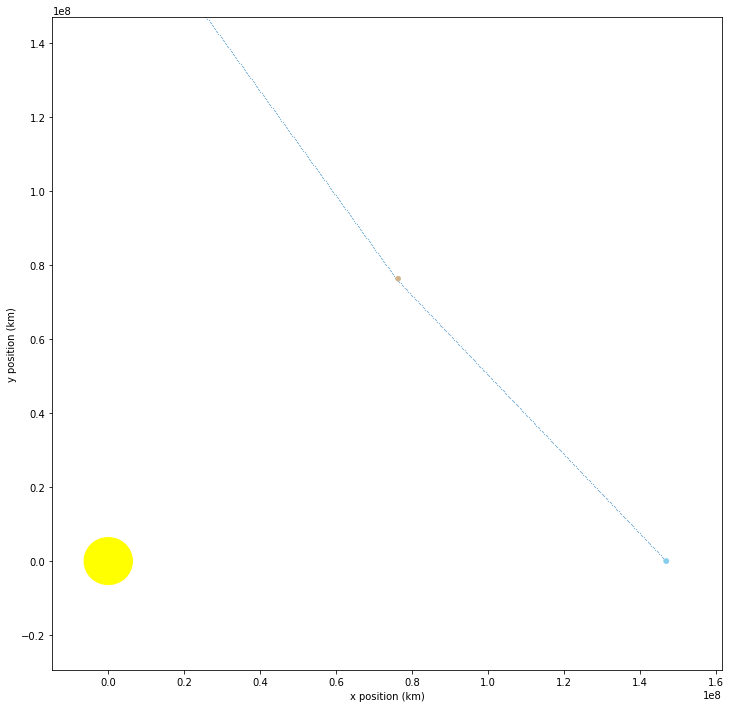

In [9]:
#Transfer Orbit

sampled_df = df[ df.index % 2500 == 0 ]

plt.figure(figsize=(12, 12))

plt.scatter(sampled_df.x_pos, sampled_df.y_pos, s=0.05)

plt.xlabel("x position (km)")
plt.ylabel("y position (km)")


# Some gibberish that draws a big yellow circle representing the Sun:
earth = plt.Circle((0.0, 0.0), 1000 * radius_of_earth, color='yellow')
plt.gcf().gca().add_artist(earth)



# Some gibberish that draws a big blue circle representing the Earth:
earth = plt.Circle(position_of_earth, 100 * radius_of_earth, color='skyblue')
plt.gcf().gca().add_artist(earth)

# Venus
venus = plt.Circle(position_of_venus, 100 * radius_of_venus, color='tan')
plt.gcf().gca().add_artist(venus)

# Make the plot big enough to show the original and final orbits:
plot_limit = earth_to_sun
plt.xlim(-0.1 * plot_limit, 1.1 * plot_limit)
plt.ylim(-0.2 * plot_limit, 1.0 * plot_limit)

plt.show()